In [1]:
!git clone 'https://github.com/aakashvardhan/s7-in-depth-practice.git'

Cloning into 's7-in-depth-practice'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 97 (delta 43), reused 82 (delta 28), pack-reused 0
Receiving objects: 100% (97/97), 198.52 KiB | 7.09 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [2]:
import sys
sys.path.append('/content/s7-in-depth-practice')
sys.path.append('/content/s7-in-depth-practice/models')

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from model_utils import model_summary, test_model_sanity, sgd_optimizer
from models.model import model3

from utils import train, test, get_device, plt_fig, get_incorrect_predictions, plot_incorrect

In [4]:
random_rotations = 7
img_size = (28,28)

# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomResizedCrop(img_size, (0.80, 1.00)),
                                       transforms.RandomRotation(random_rotations),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 144073961.59it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4230632.27it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45858307.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18300219.76it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# CUDA?
cuda = get_device()

# For reproducibility
torch.manual_seed(1)

if torch.cuda.is_available():
    torch.cuda.manual_seed(1)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
model3 = model3().to(cuda)

In [8]:
model_summary(model3)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
         ConvBlock-5            [-1, 8, 26, 26]               0
            Conv2d-6           [-1, 16, 24, 24]           1,152
              ReLU-7           [-1, 16, 24, 24]               0
       BatchNorm2d-8           [-1, 16, 24, 24]              32
           Dropout-9           [-1, 16, 24, 24]               0
        ConvBlock-10           [-1, 16, 24, 24]               0
           Conv2d-11           [-1, 16, 24, 24]           2,304
             ReLU-12           [-1, 16, 24, 24]               0
      BatchNorm2d-13           [-1, 16, 24, 24]              32
          Dropout-14           [-1, 16,

In [9]:
from torch.optim.lr_scheduler import StepLR


optimizer = sgd_optimizer(model3, 0.01)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
EPOCHS = 15
lr = []
for epoch in range(1,EPOCHS+1):
    print("EPOCH:", epoch)
    train(model3, cuda, train_loader, optimizer, epoch)
    test(model3, cuda, test_loader)
    scheduler.step()
    lr.append(optimizer.param_groups[0]['lr'])

EPOCH: 1


Loss=0.13772450387477875 Batch_id=468 Accuracy=89.84: 100%|██████████| 469/469 [00:30<00:00, 15.16it/s]



Test set: Average loss: 0.0577, Accuracy: 9827/10000 (98.27%)

EPOCH: 2


Loss=0.11966220289468765 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]



Test set: Average loss: 0.0526, Accuracy: 9833/10000 (98.33%)

EPOCH: 3


Loss=0.0866171345114708 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:34<00:00, 13.73it/s]



Test set: Average loss: 0.0388, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.1037469133734703 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s]



Test set: Average loss: 0.0431, Accuracy: 9866/10000 (98.66%)

EPOCH: 5


Loss=0.043814096599817276 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s]



Test set: Average loss: 0.0310, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.09422283619642258 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:35<00:00, 13.37it/s]



Test set: Average loss: 0.0286, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.028660161420702934 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s]



Test set: Average loss: 0.0261, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.025526627898216248 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:32<00:00, 14.29it/s]



Test set: Average loss: 0.0212, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.015834467485547066 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:30<00:00, 15.19it/s]



Test set: Average loss: 0.0206, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.011614561080932617 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:30<00:00, 15.15it/s]



Test set: Average loss: 0.0200, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.037217650562524796 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:31<00:00, 15.08it/s]



Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.0750604197382927 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:30<00:00, 15.32it/s]



Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.025419585406780243 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:32<00:00, 14.38it/s]



Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.01607583649456501 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:30<00:00, 15.18it/s]



Test set: Average loss: 0.0190, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.007503814529627562 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:31<00:00, 14.79it/s]



Test set: Average loss: 0.0186, Accuracy: 9936/10000 (99.36%)



In [10]:
incorrect, incorrect_pred, incorrect_target = get_incorrect_predictions(model3, cuda, test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


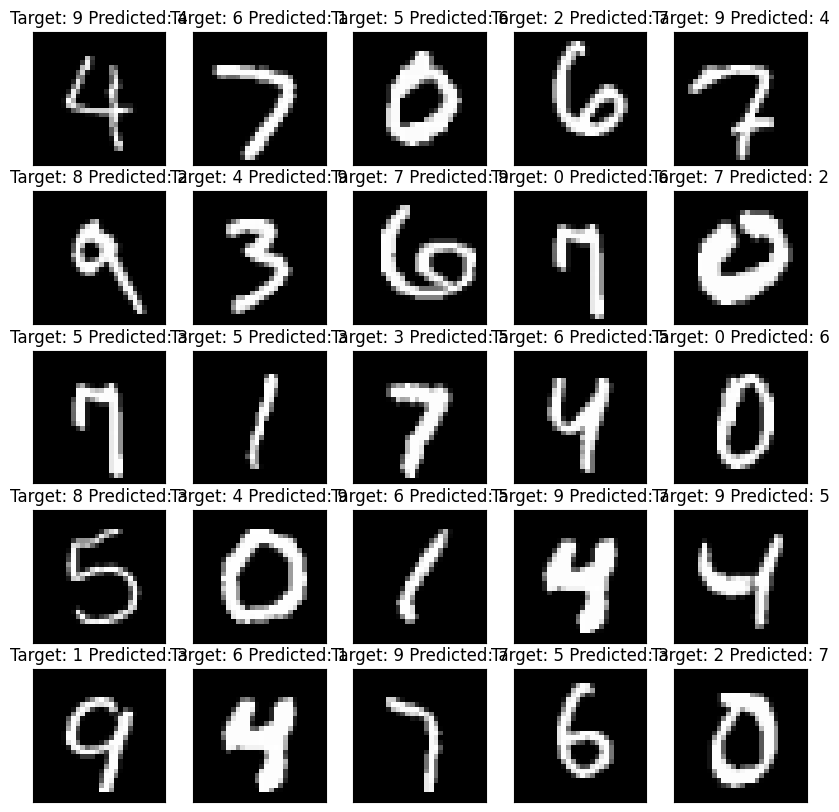

In [12]:
plot_incorrect(incorrect, incorrect_pred, incorrect_target, test_loader)

In [11]:
# Save model
torch.save(model3.state_dict(), 'best_model.pth')